<a href="https://colab.research.google.com/github/luricl/Desafios-de-Programacao-em-ML/blob/main/DPFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio de Programação Final: Modulação em fase e em Amplitude com o Autoencoder

Neste notebook, o autoenconder utilizado anteriormente será aperfeiçoado para que ele modele um sistema de comunicação tanto em fase quanto em aplitude.

## Identificação
**Nome: Lurian Correia Lima**

**Matrícula: 222005395**

## 1. Objetivo

O objetivo deste desafio é ampliar a implementação do Autoencoder iniciada no desafio anterior. Pois, é esperado que seja possível modular um sistema de comunicação tanto em fase quanto em amplitude ao final deste notebook.

No final, a performance do algoritmo será comparada com metas teóricas, estabelecidas no desafio anterior. Para efeitos de comparação, será feita o uso de diferentes modulações.

## 2. Preparação do ambiente

Primeiramente, é necessário "montar" o drive dentro do Google Colaboratory, ou seja, conseguiremos acessar diretamente todos os conteúdos presentes no Google drive, possibilitando a execução do *Jupyter Notebook* a partir, unicamente, da nuvem.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import sys

!cat '/content/drive/MyDrive/2024.1/TEE/DPFinal/utils_exp2.py'
sys.path.append('/content/drive/MyDrive/2024.1/TEE/DPFinal/')

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch

# work with math and erfc
import math
from scipy.special import erfc

from pylab import *
from sklearn.manifold import TSNE

# Função Q(x)
def func_q(x):
    return (1/2)*erfc((1/math.sqrt(2))*x)

# Detector ótimo para os esquemas tradicionais de modulação
def genareteBER(M, EbNodB_range):
    # gera o vetor de BER para cada uma das modulações tradicionais: M-ASK, M-PSK e M-QAM para 
    # uma dada lista de SNRs
    m_ask = [None]*len(EbNodB_range)
    m_psk = [None]*len(EbNodB_range)
    m_qam = [None]*len(EbNodB_range)
    for n in range(0,len(EbNodB_range)):
        EbNo=10.0**(EbNodB_range[n]/10.0)
        m_ask[n] = 2*(1-(1/M))*func_q((math.sqrt((6*math.log2(M))/(M**2-1)*EbNo)))
        m_psk[n] = 2*func_q(math.sin(math.pi/M)*math.sqrt(2*math.log2(M)*EbNo))
        

Em seguida, deve-se importar todas as bibliotecas necessárias

In [ ]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# work with math and erfc
import math
from scipy.special import erfc

# aditional modules for vizualisation
from pylab import *
from sklearn.manifold import TSNE

# complementary functions
import utils_exp2

## 3.Criação do Autoencoder
### 3.1 Implementação do modelo

Para a criação do Autoencoder, define-se a classe ```autoencoder``` que recebe como parâmetros de inicialização:

- ```M```: Quantidade de mensagens
- ```n_channel```: Número de usos do canal
- ```n_simbolos```: Número de símbolos
- ```EbN0```: Relação sinal-ruído desejada para o treinamento

In [ ]:
# Definição da Classe Autoencoder
class autoencoder(nn.Module):
    def __init__(self, M, n_channel, n_simbolos, EbN0):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(M, n_channel*n_simbolos, bias=True),
            nn.ReLU(True),
            nn.Linear(n_channel*n_simbolos, n_channel*n_simbolos, bias=True),
            nn.BatchNorm1d(n_channel*n_simbolos, affine=True))
        self.decoder = nn.Sequential(
            nn.Linear(n_channel*n_simbolos, M, bias=True),
            nn.ReLU(True),
            nn.Linear(M, M, bias=True),
            nn.Softmax())

    def forward(self, x, R, n_channel, n_simbolos, EbN0):
        outs = {}
        # Número de linhas de x
        x_size = x.shape[0]

        # Encoder Layer
        x = self.encoder(x)
        # Normalização Euclidiana
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*(math.sqrt(n_channel))
        # Saída do vetor codificado e normalizado
        outs['encoded'] = x

        # Channel Influence
        # Cria-se o vetor de ruído
        noise_channel = torch.normal(0.0, math.sqrt(1/(2*R*(10.0**(EbN0/10.0)))),[x_size, n_channel*n_simbolos])
        # Influencia do Canal - Soma com o ruído
        x = x + noise_channel
        # Saída do vetor com ruído
        outs['encoded_noise'] = x

        # Decoder Layer
        x = self.decoder(x)
        # Saída do vetor de decodificado
        outs['decoded'] = x
        return outs

    def auto_encoder(self, x, n_channel):
        x = self.encoder(x)
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*(n_channel/math.sqrt(n_channel))
        return x

    def auto_decoder(self, x):
        x = self.decoder(x)
        return x

### 3.2 Treinamento do modelo

É necessário definir uma função de definição dos parâmetros de treinamento do modelo, uma função de treinamento e uma função de plotagem do processo de treinamento do modelo

In [ ]:
def get_train_params(M):
  # Parametros de treinamento
  # Taxa de aprendizado
  learning_rate = float(input("learning rate = "))

  # Quantidade de épocas de treinamento
  num_epochs = int(input("num_epochs = "))

  # Tamanho do conjunto de cada treinamento - batch size
  batch_size = 10*M

  # Qunatidade de amostras de treinamento
  N_treino = batch_size*10

  return learning_rate, num_epochs, batch_size, N_treino


In [ ]:
# Treinamento do AE
def train(model, M, R, n_channel, n_simbolos, EbN0, learning_rate, num_epochs, batch_size, N_treino):
  # Montagem do dataset de treino
  train_dataset = torch.eye(M)
  data = train_dataset.repeat(int(N_treino/M),1)

  # Função de perda do treinamento
  criterion = nn.CrossEntropyLoss()

  # Algortimo de otimização
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

  # Para guardar os valores de loss
  loss_epoch = []

  for epoch in range(num_epochs):
      # Definição do dataset (aleatório para cada época)
      dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

      # Para cada batch size em 'dataloader'
      for input_in in dataloader:
          # Codificação do sinal de entrada
          output = model(input_in, R, n_channel, n_simbolos, EbN0)
          # Formatação dos dados para comparação na função de custo
          target_crossEntropy = torch.argmax(input_in, dim=-1).type(torch.LongTensor)
          # Cross-Entropy Loss
          loss = criterion(output['decoded'], target_crossEntropy)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      loss_epoch.append(loss.data)
      print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch + 1, num_epochs, loss.data))

  return model, loss_epoch

In [ ]:
# Define função de plotagem do treino
def plot_train(loss_epoch, n_channel, k):
  # Plot da curva de Loss
  vector_loss = np.arange(0,len(loss_epoch),1)
  fig = plt.figure(figsize=(10,8))
  plt.plot(vector_loss,loss_epoch,'b',label='Autoencoder(%d,%d)'%(n_channel, k))
  plt.xlabel('Epoca')
  plt.ylabel('Loss')
  plt.title('Loss por Época')
  plt.legend(loc='lower left',ncol = 1)
  plt.grid()
  plt.show()

### 3.3 Teste do modelo

Para o teste do modelo, cria-se uma função que recebe o modelo a ser treinado, a quantidade de

In [ ]:
def test_and_plot_model(model, M, R, n_channel, n_simbolos, k, mod):
  # Paramêtros de Teste
  N_teste = 100000*M
  test_label = torch.randint(0, M, (N_teste,))
  test_data = torch.nn.functional.one_hot(test_label).float()

  # Variáveis de teste
  # Range de valores de relações sinal-ruído
  EbNodB_range = torch.arange(0,8,0.5)
  # Cria um vetor vazio para o registro dos valores de BER
  ber = [None]*len(EbNodB_range)

  # Teste do modelo treinado e cálculo da BER
  for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo)).item()
    noise_mean = 0.0
    no_errors = 0
    noise = torch.normal(noise_mean, noise_std,[N_teste, n_channel*n_simbolos])

    # Embaralhamneto do dataset de teste
    data = TensorDataset(test_data, torch.LongTensor(test_label))
    dataloader_test = DataLoader(data, batch_size=N_teste, shuffle=True)

    # Dividindo o dataset em labels e dados
    test_data_ = dataloader_test.dataset.tensors[0]
    label_ = np.array(dataloader_test.dataset.tensors[1])

    # Codificação do sinal
    encoded_signal = model.auto_encoder(test_data_, n_channel*n_simbolos/2)

    # Influencia do Canal
    channel_signal = encoded_signal + noise

    # Decodificação do sinal
    pred_final_signal = model.auto_decoder(channel_signal)
    parse_pred_output = pred_final_signal.tolist()
    pred_output = np.argmax(parse_pred_output,axis=1)   #retorna um array com a posição de maior argumento

    # Calculo da BER
    no_errors = (pred_output != label_)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / N_teste
    print ('SNR:',EbNodB_range[n].item(),'BLER:',ber[n], 'no_errors:',no_errors)

  # Plot da curva de BER
  # Curvas do detector ótimo
  #-- Gera as curvas téoricas para as moduações ASK, PSK e QAM para um dado M e intervalos de SNR
  _, psk_M, qam_M = utils_exp2.genareteBER(2**k, EbNodB_range)

  fig = plt.figure(figsize=(10,8))
  fig_title = "Curvas de BLER para Autoencoder("+str(n_channel)+","+str(k)+")"

  if mod == 'psk':
    plt.plot(EbNodB_range, psk_M, 'go',label='psk_M')
  else:
    plt.plot(EbNodB_range, qam_M, 'ko',label='qam_M')

  plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(%d,%d)'%(n_channel, k))
  plt.yscale('log')
  plt.xlabel('SNR Range')
  plt.ylabel('BLER')
  plt.title(fig_title)
  plt.grid()
  plt.legend(loc='lower left',ncol = 1)
  plt.show()

  return model

### 3.4 Resultados do modelo

In [ ]:
def results(model, M, n_channel):
  # Mensagens codificadas pelo Encoder
  data_encoded_symbol = model.auto_encoder(torch.eye(M),n_channel)

  # Separação dos símbolos em real e imaginário
  real_symb, imag_symb = utils_exp2.split_symb(data_encoded_symbol)

  # Plotagem das constelações por uso do canal
  utils_exp2.plot_graphs(real_symb.detach().numpy(),imag_symb.detach().numpy(),n_channel,sizefig=5)

### 4. Exercícios

### 4.1 Modulação PSK com n = 1 e k = 2

Neste exercício, é esperado que o gráfico de constelação se assemelhe com um círculo, pois, como há apenas um uso do canal, a amplitude é constante para todos os pontos.

Além disso, é esperado também que a curva BLER do autoenconder seja semelhante à curva teórica, ou seja, próximo do limite de Shannon.

learning rate = 0.01
num_epochs = 1500
epoch [1/1500], loss:1.3827
epoch [2/1500], loss:1.3408
epoch [3/1500], loss:1.2766
epoch [4/1500], loss:1.2337
epoch [5/1500], loss:1.1131
epoch [6/1500], loss:1.0508
epoch [7/1500], loss:1.0877
epoch [8/1500], loss:0.9166
epoch [9/1500], loss:0.8819
epoch [10/1500], loss:0.8478
epoch [11/1500], loss:0.8548
epoch [12/1500], loss:0.8192
epoch [13/1500], loss:0.7997
epoch [14/1500], loss:0.7879
epoch [15/1500], loss:0.7839
epoch [16/1500], loss:0.7800
epoch [17/1500], loss:0.7669
epoch [18/1500], loss:0.7734
epoch [19/1500], loss:0.7691
epoch [20/1500], loss:0.7671
epoch [21/1500], loss:0.7791
epoch [22/1500], loss:0.7618
epoch [23/1500], loss:0.7674
epoch [24/1500], loss:0.7651
epoch [25/1500], loss:0.7631
epoch [26/1500], loss:0.7702
epoch [27/1500], loss:0.7528
epoch [28/1500], loss:0.7552
epoch [29/1500], loss:0.7648
epoch [30/1500], loss:0.7485
epoch [31/1500], loss:0.7507
epoch [32/1500], loss:0.7505
epoch [33/1500], loss:0.7499
epoch [34/150

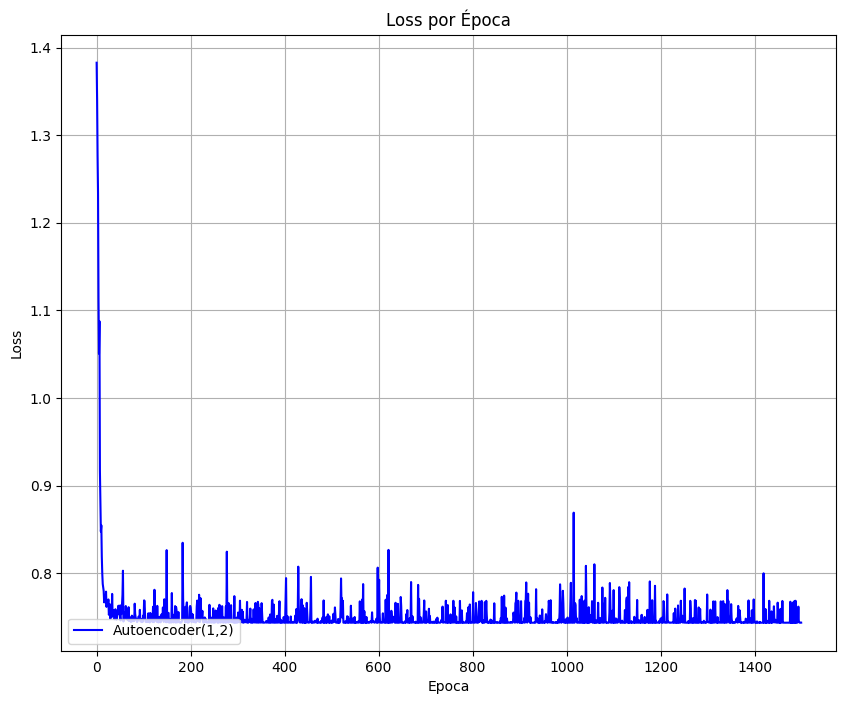

In [ ]:
# Parametros do modelo de Autoencoder
# Número de bits do sinal mensagem
k = 2

# Número de usos do canal
n_channel = 1

# Quantidade de mensagens possíveis
M = 2**k

# Taxa de bits por uso do canal
R = k/n_channel

# Relação sinal-ruído desejada para o treinamento
EbN0 = 7

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

# Criação do Autoencoder
model = autoencoder(M, n_channel, n_simbolos, EbN0)

# Treino do modelo
# Define os hiperparâmetros
learning_rate, num_epochs, batch_size, N_treino = get_train_params(M)

# treina o modelo
model, loss_epoch = train(model, M, R, n_channel, n_simbolos, EbN0, learning_rate, num_epochs, batch_size, N_treino)

# plota o resultado do treinamento
plot_train(loss_epoch, n_channel, k)

SNR: 0.0 BLER: 0.158105 no_errors: 63242
SNR: 0.5 BLER: 0.13729 no_errors: 54916
SNR: 1.0 BLER: 0.1163175 no_errors: 46527
SNR: 1.5 BLER: 0.0982575 no_errors: 39303
SNR: 2.0 BLER: 0.0813425 no_errors: 32537
SNR: 2.5 BLER: 0.065615 no_errors: 26246
SNR: 3.0 BLER: 0.05196 no_errors: 20784
SNR: 3.5 BLER: 0.04049 no_errors: 16196
SNR: 4.0 BLER: 0.03029 no_errors: 12116
SNR: 4.5 BLER: 0.0220875 no_errors: 8835
SNR: 5.0 BLER: 0.01602 no_errors: 6408
SNR: 5.5 BLER: 0.01075 no_errors: 4300
SNR: 6.0 BLER: 0.0073 no_errors: 2920
SNR: 6.5 BLER: 0.0046575 no_errors: 1863
SNR: 7.0 BLER: 0.002875 no_errors: 1150
SNR: 7.5 BLER: 0.0016025 no_errors: 641


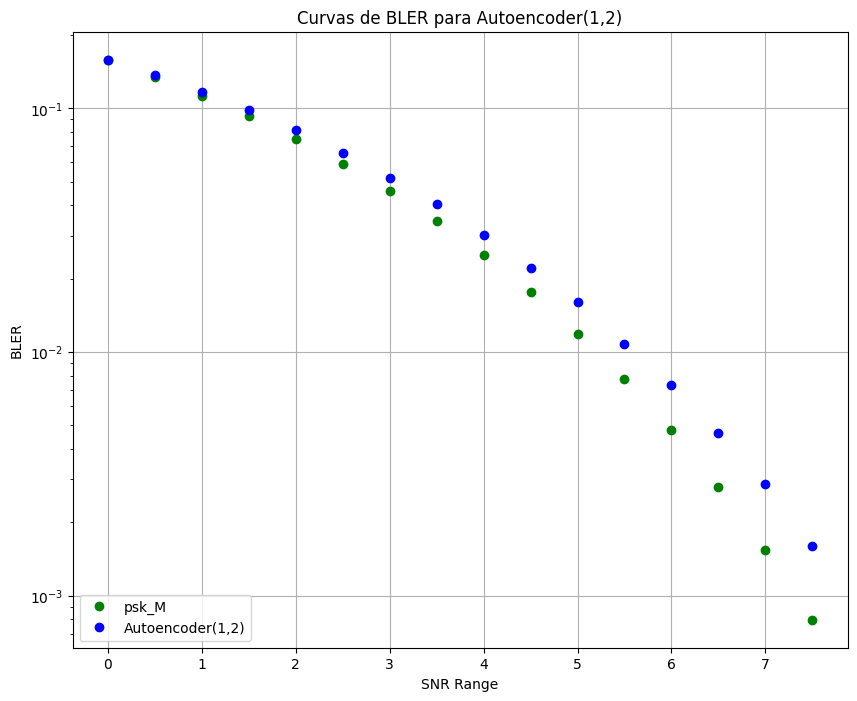

In [ ]:
model = test_and_plot_model(model, M, R, n_channel, n_simbolos, k, 'psk')

<Figure size 640x480 with 0 Axes>

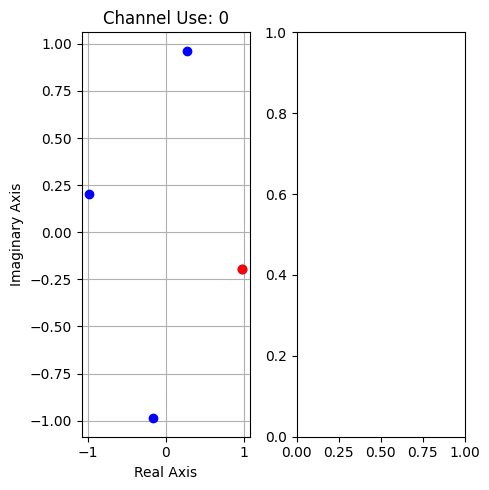

In [ ]:
results(model, M, n_channel)

### 4.2 Modulação PSK com n = 2 e k = 2

Neste exercício, é esperado que o Autoencoder possua eficiência melhor do que a curva teórica, pelo fato de que há mais de um uso do canal, o que favorece o funcionamento da rede, em comparação com o PSK teórico.

No gráfico de constelação é esperado que a soma das amplitudes de cada ponto seja igual à quantidade de usos do canal.

learning rate = 0.01
num_epochs = 500
epoch [1/500], loss:1.3534
epoch [2/500], loss:1.2776
epoch [3/500], loss:1.1920
epoch [4/500], loss:1.1989
epoch [5/500], loss:1.1320
epoch [6/500], loss:1.0077
epoch [7/500], loss:1.0114
epoch [8/500], loss:0.9715
epoch [9/500], loss:0.9558
epoch [10/500], loss:0.8704
epoch [11/500], loss:0.8509
epoch [12/500], loss:0.8349
epoch [13/500], loss:0.8554
epoch [14/500], loss:0.8015
epoch [15/500], loss:0.8115
epoch [16/500], loss:0.8098
epoch [17/500], loss:0.7980
epoch [18/500], loss:0.8063
epoch [19/500], loss:0.8036
epoch [20/500], loss:0.8056
epoch [21/500], loss:0.7803
epoch [22/500], loss:0.7751
epoch [23/500], loss:0.7777
epoch [24/500], loss:0.7833
epoch [25/500], loss:0.7655
epoch [26/500], loss:0.7928
epoch [27/500], loss:0.7784
epoch [28/500], loss:0.7864
epoch [29/500], loss:0.7683
epoch [30/500], loss:0.7807
epoch [31/500], loss:0.7646
epoch [32/500], loss:0.7793
epoch [33/500], loss:0.7795
epoch [34/500], loss:0.7665
epoch [35/500], los

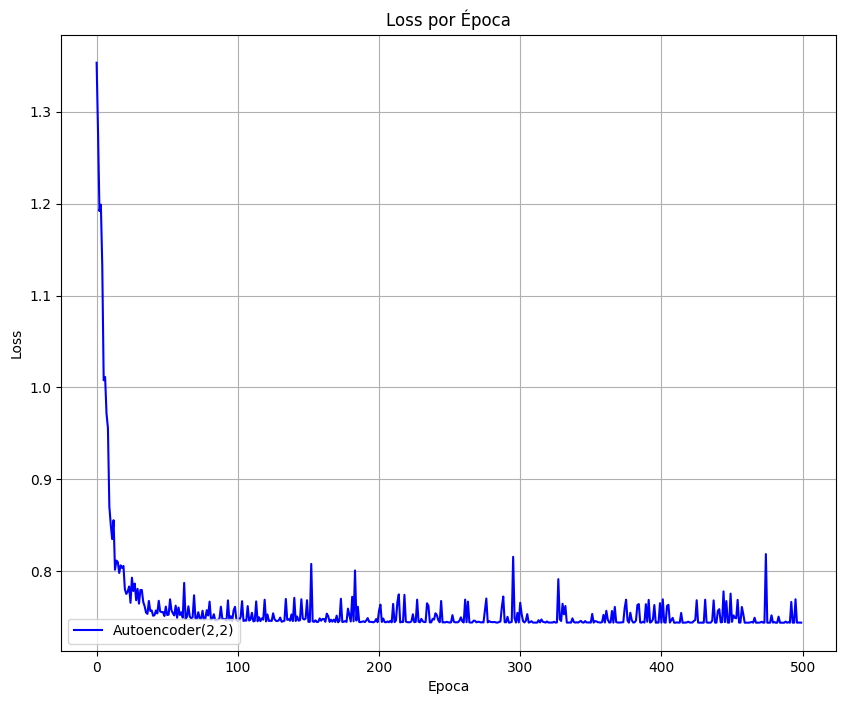

In [ ]:
# Parametros do modelo de Autoencoder
# Número de bits do sinal mensagem
k = 2

# Número de usos do canal
n_channel = 2

# Quantidade de mensagens possíveis
M = 2**k

# Taxa de bits por uso do canal
R = k/n_channel

# Relação sinal-ruído desejada para o treinamento
EbN0 = 7

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

# Criação do Autoencoder
model = autoencoder(M, n_channel, n_simbolos, EbN0)

# Treina o modelo
learning_rate, num_epochs, batch_size, N_treino = get_train_params(M)
model, loss_epoch = train(model, M, R, n_channel, n_simbolos, EbN0, learning_rate, num_epochs, batch_size, N_treino)
plot_train(loss_epoch, n_channel, k)

SNR: 0.0 BLER: 0.1533825 no_errors: 61353
SNR: 0.5 BLER: 0.131945 no_errors: 52778
SNR: 1.0 BLER: 0.1124325 no_errors: 44973
SNR: 1.5 BLER: 0.093825 no_errors: 37530
SNR: 2.0 BLER: 0.077045 no_errors: 30818
SNR: 2.5 BLER: 0.0616775 no_errors: 24671
SNR: 3.0 BLER: 0.047615 no_errors: 19046
SNR: 3.5 BLER: 0.0366875 no_errors: 14675
SNR: 4.0 BLER: 0.0274125 no_errors: 10965
SNR: 4.5 BLER: 0.0194475 no_errors: 7779
SNR: 5.0 BLER: 0.0135525 no_errors: 5421
SNR: 5.5 BLER: 0.009145 no_errors: 3658
SNR: 6.0 BLER: 0.0058275 no_errors: 2331
SNR: 6.5 BLER: 0.0037175 no_errors: 1487
SNR: 7.0 BLER: 0.0020275 no_errors: 811
SNR: 7.5 BLER: 0.0011625 no_errors: 465


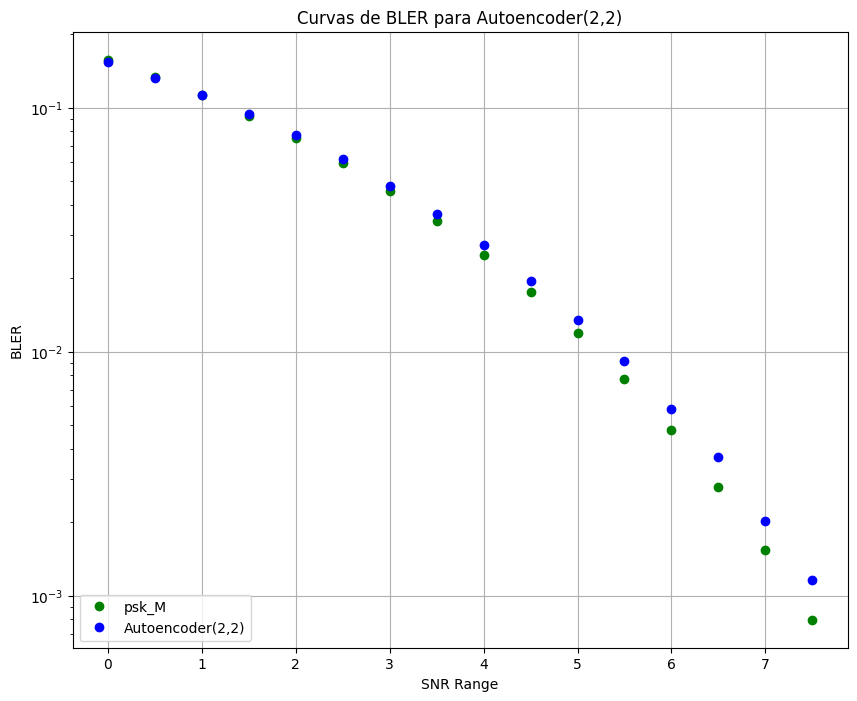

In [ ]:
model = test_and_plot_model(model, M, R, n_channel, n_simbolos, k, 'psk')

<Figure size 640x480 with 0 Axes>

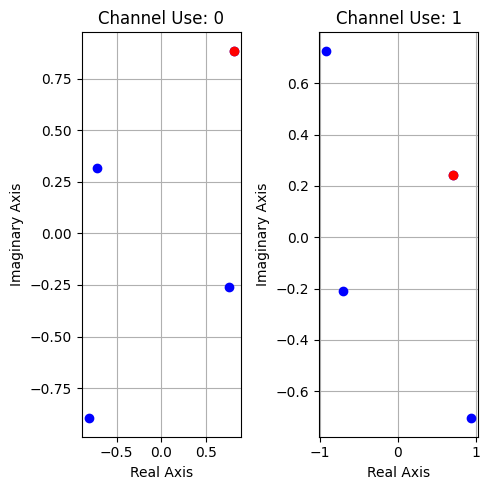

In [ ]:
results(model, M, n_channel)

### 4.3 Modulação QAM com n = 3 e k = 2

Nesta etapa, o desempenho do autoencoder será comparado à performance da modulação QAM teórica, que combina tanto a modulação em fase quanto em amplitude.

É esperado que o Autoencoder possua um desempenho melhor do que o teórico e que o gráfico de constelação possua a soma da amplitude dos pontos igual à quantidade de usos do canal.

learning rate = 0.001
num_epochs = 500
epoch [1/500], loss:1.3854
epoch [2/500], loss:1.3893
epoch [3/500], loss:1.3732
epoch [4/500], loss:1.3728
epoch [5/500], loss:1.3595
epoch [6/500], loss:1.3424
epoch [7/500], loss:1.3438
epoch [8/500], loss:1.3219
epoch [9/500], loss:1.3055
epoch [10/500], loss:1.3069
epoch [11/500], loss:1.2919
epoch [12/500], loss:1.2742
epoch [13/500], loss:1.2608
epoch [14/500], loss:1.2326
epoch [15/500], loss:1.2302
epoch [16/500], loss:1.2467
epoch [17/500], loss:1.2303
epoch [18/500], loss:1.1640
epoch [19/500], loss:1.1802
epoch [20/500], loss:1.1197
epoch [21/500], loss:1.1135
epoch [22/500], loss:1.1553
epoch [23/500], loss:1.1571
epoch [24/500], loss:1.1287
epoch [25/500], loss:1.0664
epoch [26/500], loss:1.0730
epoch [27/500], loss:1.0816
epoch [28/500], loss:1.0759
epoch [29/500], loss:1.0257
epoch [30/500], loss:1.0564
epoch [31/500], loss:1.0891
epoch [32/500], loss:1.1131
epoch [33/500], loss:1.0548
epoch [34/500], loss:1.0264
epoch [35/500], lo

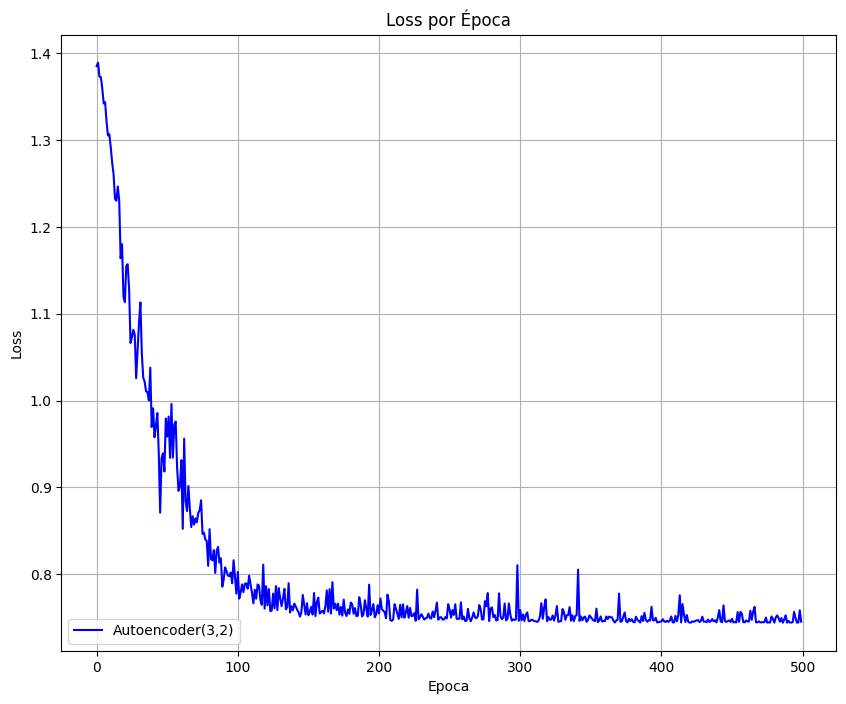

In [ ]:
# Parametros do modelo de Autoencoder
# Número de bits do sinal mensagem
k = 2

# Número de usos do canal
n_channel = 3

# Quantidade de mensagens possíveis
M = 2**k

# Taxa de bits por uso do canal
R = k/n_channel

# Relação sinal-ruído desejada para o treinamento
EbN0 = 7

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

# Criação do Autoencoder
model = autoencoder(M, n_channel, n_simbolos, EbN0)

# Treina o modelo
learning_rate, num_epochs, batch_size, N_treino = get_train_params(M)
model, loss_epoch = train(model, M, R, n_channel, n_simbolos, EbN0, learning_rate, num_epochs, batch_size, N_treino)
plot_train(loss_epoch, n_channel, k)

SNR: 0.0 BLER: 0.14123 no_errors: 56492
SNR: 0.5 BLER: 0.11936 no_errors: 47744
SNR: 1.0 BLER: 0.09971 no_errors: 39884
SNR: 1.5 BLER: 0.08199 no_errors: 32796
SNR: 2.0 BLER: 0.065905 no_errors: 26362
SNR: 2.5 BLER: 0.051765 no_errors: 20706
SNR: 3.0 BLER: 0.03884 no_errors: 15536
SNR: 3.5 BLER: 0.0294975 no_errors: 11799
SNR: 4.0 BLER: 0.0214025 no_errors: 8561
SNR: 4.5 BLER: 0.0143225 no_errors: 5729
SNR: 5.0 BLER: 0.009605 no_errors: 3842
SNR: 5.5 BLER: 0.00628 no_errors: 2512
SNR: 6.0 BLER: 0.00382 no_errors: 1528
SNR: 6.5 BLER: 0.00219 no_errors: 876
SNR: 7.0 BLER: 0.001245 no_errors: 498
SNR: 7.5 BLER: 0.0006275 no_errors: 251


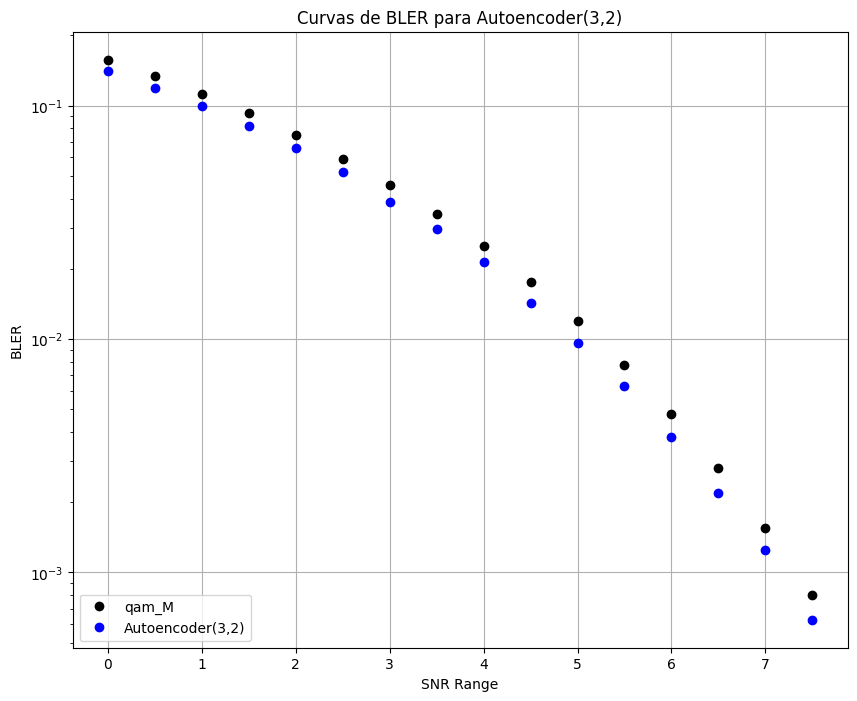

In [ ]:
model = test_and_plot_model(model, M, R, n_channel, n_simbolos, k, 'qam')

<Figure size 640x480 with 0 Axes>

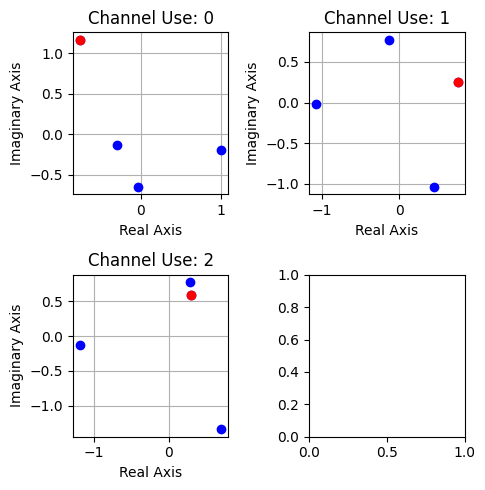

In [ ]:
results(model, M, n_channel)

### 4.4 Modulação PSK com n = 2 e k = 3

Neste exercío, como a quantidade de usos do canal é maior do que 1, espera-se que o Autoencoder possua desempenho melhor do que o teórico feito pela modulação PSK.

learning rate = 0.01
num_epochs = 500
epoch [1/500], loss:2.0574
epoch [2/500], loss:2.0119
epoch [3/500], loss:1.9459
epoch [4/500], loss:1.8363
epoch [5/500], loss:1.7924
epoch [6/500], loss:1.6900
epoch [7/500], loss:1.5837
epoch [8/500], loss:1.5253
epoch [9/500], loss:1.4167
epoch [10/500], loss:1.4195
epoch [11/500], loss:1.3547
epoch [12/500], loss:1.3337
epoch [13/500], loss:1.3092
epoch [14/500], loss:1.3156
epoch [15/500], loss:1.3098
epoch [16/500], loss:1.3158
epoch [17/500], loss:1.3020
epoch [18/500], loss:1.3279
epoch [19/500], loss:1.3036
epoch [20/500], loss:1.2935
epoch [21/500], loss:1.3129
epoch [22/500], loss:1.3768
epoch [23/500], loss:1.2942
epoch [24/500], loss:1.2904
epoch [25/500], loss:1.2823
epoch [26/500], loss:1.2968
epoch [27/500], loss:1.2952
epoch [28/500], loss:1.2889
epoch [29/500], loss:1.2833
epoch [30/500], loss:1.2877
epoch [31/500], loss:1.2976
epoch [32/500], loss:1.2864
epoch [33/500], loss:1.2869
epoch [34/500], loss:1.2834
epoch [35/500], los

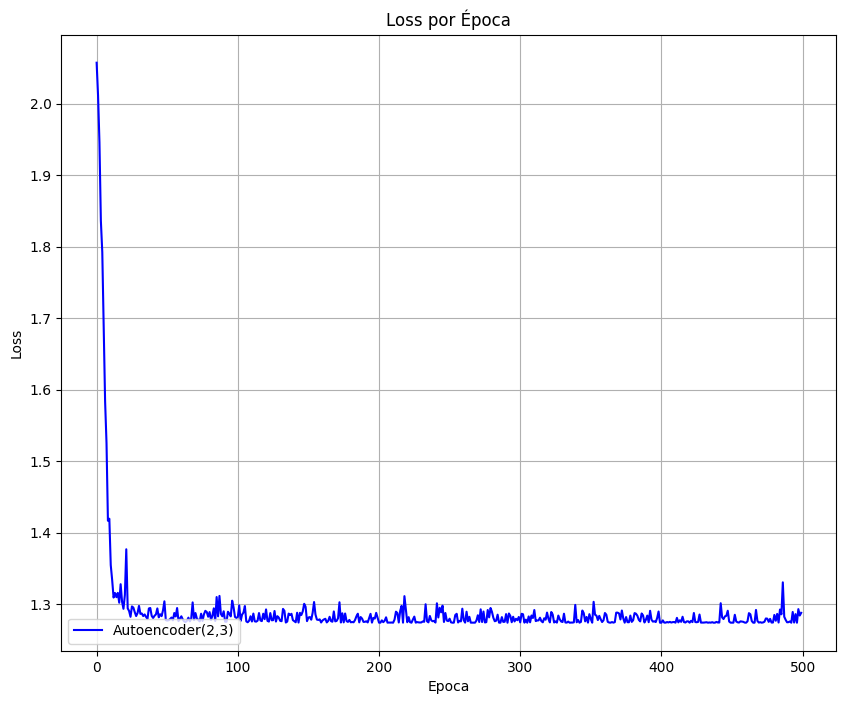

In [ ]:
# Parametros do modelo de Autoencoder
# Número de bits do sinal mensagem
k = 3

# Número de usos do canal
n_channel = 2

# Quantidade de mensagens possíveis
M = 2**k

# Taxa de bits por uso do canal
R = k/n_channel

# Relação sinal-ruído desejada para o treinamento
EbN0 = 7

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

# Criação do Autoencoder
model = autoencoder(M, n_channel, n_simbolos, EbN0)

# Treina o modelo
learning_rate, num_epochs, batch_size, N_treino = get_train_params(M)
model, loss_epoch = train(model, M, R, n_channel, n_simbolos, EbN0, learning_rate, num_epochs, batch_size, N_treino)
plot_train(loss_epoch, n_channel, k)

SNR: 0.0 BLER: 0.21905 no_errors: 175240
SNR: 0.5 BLER: 0.18926375 no_errors: 151411
SNR: 1.0 BLER: 0.16149125 no_errors: 129193
SNR: 1.5 BLER: 0.13408 no_errors: 107264
SNR: 2.0 BLER: 0.10962 no_errors: 87696
SNR: 2.5 BLER: 0.08793375 no_errors: 70347
SNR: 3.0 BLER: 0.0683375 no_errors: 54670
SNR: 3.5 BLER: 0.05197125 no_errors: 41577
SNR: 4.0 BLER: 0.03807875 no_errors: 30463
SNR: 4.5 BLER: 0.02746 no_errors: 21968
SNR: 5.0 BLER: 0.0186025 no_errors: 14882
SNR: 5.5 BLER: 0.01235375 no_errors: 9883
SNR: 6.0 BLER: 0.00785625 no_errors: 6285
SNR: 6.5 BLER: 0.00451875 no_errors: 3615
SNR: 7.0 BLER: 0.00264375 no_errors: 2115
SNR: 7.5 BLER: 0.00143125 no_errors: 1145


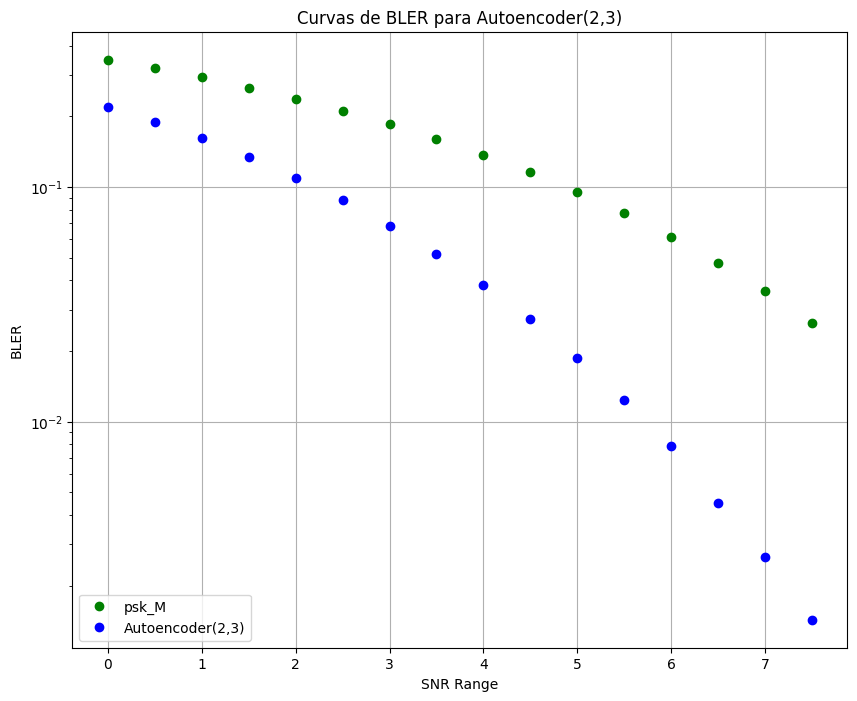

In [ ]:
model = test_and_plot_model(model, M, R, n_channel, n_simbolos, k, 'psk')

<Figure size 640x480 with 0 Axes>

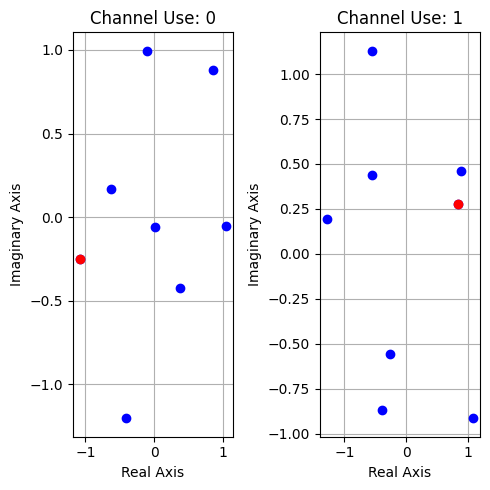

In [ ]:
results(model, M, n_channel)

### 4.5 Modulação QAM com n = 2 e k = 3

De modo semelhante ao exercício anterior, espera-se que, mesmo com a variação da quantidade de usos do canal(n) e da quantidade de bits por símbolo(k) o desempenho do Autoencoder ainda seja melhor do que o desempenho da modulação teórica.

learning rate = 0.01
num_epochs = 500
epoch [1/500], loss:2.0379
epoch [2/500], loss:1.9693
epoch [3/500], loss:1.9432
epoch [4/500], loss:1.7782
epoch [5/500], loss:1.6985
epoch [6/500], loss:1.6028
epoch [7/500], loss:1.5836
epoch [8/500], loss:1.4497
epoch [9/500], loss:1.3895
epoch [10/500], loss:1.3274
epoch [11/500], loss:1.3588
epoch [12/500], loss:1.3165
epoch [13/500], loss:1.3139
epoch [14/500], loss:1.2929
epoch [15/500], loss:1.2954
epoch [16/500], loss:1.2998
epoch [17/500], loss:1.3047
epoch [18/500], loss:1.2885
epoch [19/500], loss:1.2875
epoch [20/500], loss:1.3008
epoch [21/500], loss:1.2844
epoch [22/500], loss:1.2857
epoch [23/500], loss:1.2855
epoch [24/500], loss:1.2880
epoch [25/500], loss:1.2841
epoch [26/500], loss:1.2841
epoch [27/500], loss:1.2952
epoch [28/500], loss:1.3061
epoch [29/500], loss:1.3080
epoch [30/500], loss:1.2938
epoch [31/500], loss:1.2853
epoch [32/500], loss:1.2813
epoch [33/500], loss:1.2852
epoch [34/500], loss:1.2872
epoch [35/500], los

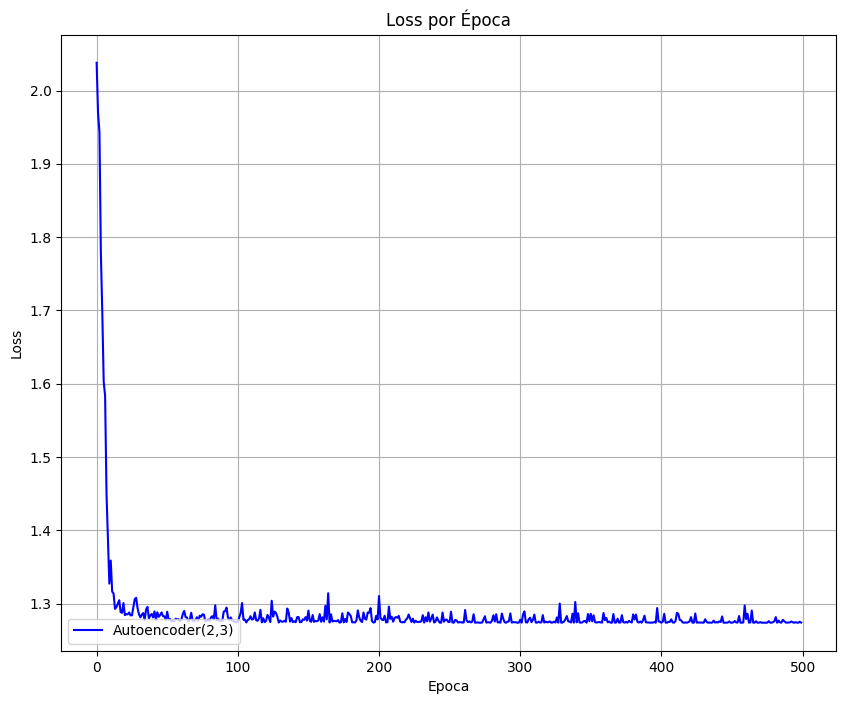

In [ ]:
# Parametros do modelo de Autoencoder
# Número de bits do sinal mensagem
k = 3

# Número de usos do canal
n_channel = 2

# Quantidade de mensagens possíveis
M = 2**k

# Taxa de bits por uso do canal
R = k/n_channel

# Relação sinal-ruído desejada para o treinamento
EbN0 = 7

# Transmisão de símbolos complexos (IQ)
#-- Para transmissão de símbolos reais basta fazer essa variável igual a 1
n_simbolos = 2

# Criação do Autoencoder
model = autoencoder(M, n_channel, n_simbolos, EbN0)

# Treina o modelo
learning_rate, num_epochs, batch_size, N_treino = get_train_params(M)
model, loss_epoch = train(model, M, R, n_channel, n_simbolos, EbN0, learning_rate, num_epochs, batch_size, N_treino)
plot_train(loss_epoch, n_channel, k)

SNR: 0.0 BLER: 0.1836275 no_errors: 146902
SNR: 0.5 BLER: 0.1544175 no_errors: 123534
SNR: 1.0 BLER: 0.1270275 no_errors: 101622
SNR: 1.5 BLER: 0.10246875 no_errors: 81975
SNR: 2.0 BLER: 0.079835 no_errors: 63868
SNR: 2.5 BLER: 0.06175625 no_errors: 49405
SNR: 3.0 BLER: 0.04558 no_errors: 36464
SNR: 3.5 BLER: 0.03269125 no_errors: 26153
SNR: 4.0 BLER: 0.02234875 no_errors: 17879
SNR: 4.5 BLER: 0.0149975 no_errors: 11998
SNR: 5.0 BLER: 0.00947125 no_errors: 7577
SNR: 5.5 BLER: 0.00569375 no_errors: 4555
SNR: 6.0 BLER: 0.00335125 no_errors: 2681
SNR: 6.5 BLER: 0.00178125 no_errors: 1425
SNR: 7.0 BLER: 0.000915 no_errors: 732
SNR: 7.5 BLER: 0.000415 no_errors: 332


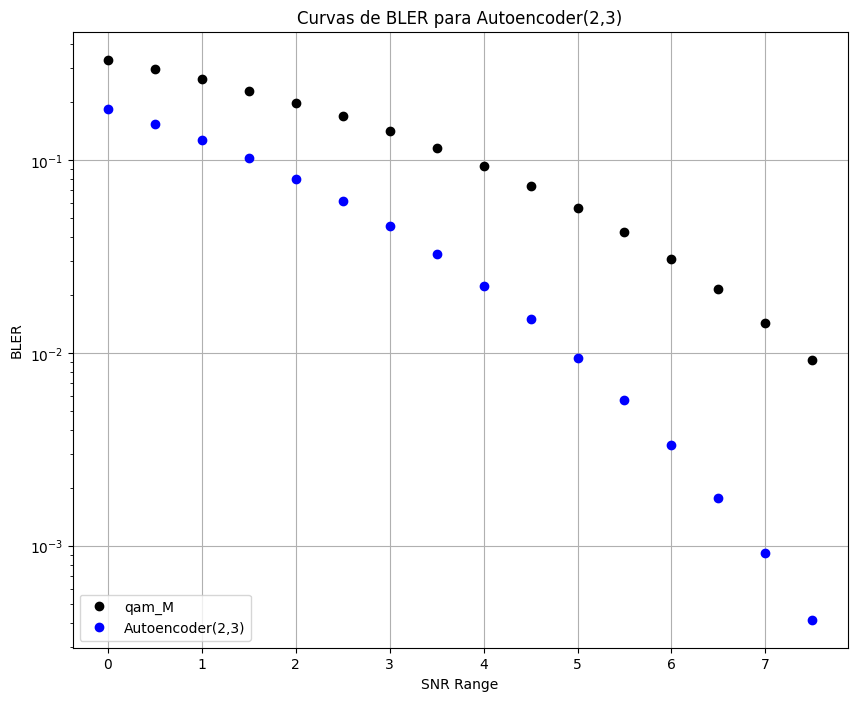

In [ ]:
model = test_and_plot_model(model, M, R, n_channel, n_simbolos, k, 'qam')

<Figure size 640x480 with 0 Axes>

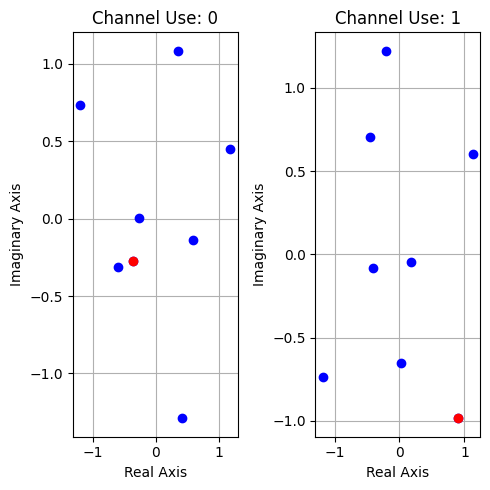

In [ ]:
results(model, M, n_channel)

## Referências

1. https://www.tutorialspoint.com/digital_communication/digital_communication_phase_shift_keying.htm
2. https://en.wikipedia.org/wiki/Constellation_diagram
3. https://en.wikipedia.org/wiki/Noisy-channel_coding_theorem
4. https://info.support.huawei.com/info-finder/encyclopedia/en/QAM.html
